In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import treecorr
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(68.81,.295) #fiducial cosmo from redmine
from scipy.optimize import minimize

class NNProcessor (object) :

    def __init__(self,min_z,delta_z,do3D=False):

        self.min_z = min_z
        self.delta_z = delta_z
        self.do3D = do3D

        self.dm_xi = None
        self.dm_varxi = None

        self.gal_xi = None
        self.gal_varxi = None
        
        self.noisy_dm_xi = None
        self.noisy_dm_varxi = None

        self.gal_RM_xi = None
        self.gal_RM_varxi = None

        self.bins = None
        
        self.cpd_bins = None
        self.cpd_wthetas = None
        
        self.theory = None
        self.theory_interp = None
        self.theory_b1 = None
        
        theory_dict = {.2:1,.3:2,.4:3,.5:4}
        if (self.delta_z == .1) & (self.min_z in theory_dict.keys()):
            self.theory_index = theory_dict[self.min_z]
        else:
            self.theory_index = None

        self.b1 = None
        self.b1_xcorr = None
        self.b1RM = None

        self.full_dm_data = None
        self.dm_data = None
        self.dm_randoms = None
        
        self.full_noisy_dm_data = None
        self.noisy_dm_data = None
        self.noisy_dm_randoms = None

        self.full_gal_data = None
        self.gal_data = None
        self.gal_randoms = None
        
        self.full_gal_RM_data = None
        self.gal_RM_data = None
        self.gal_RM_randoms = None

        self.xcorr = None
        self.xcorr_var = None
        
        self.spec_weights = None
        self.rm_weights = None

    def load_data(self):

        data = np.load(os.path.expandvars('$DES_SIMS')+'/processed_input/dark_matter/dm_3x_good_data.npy')
        self.full_dm_data = data
        randoms = np.load(os.path.expandvars('$DES_SIMS')+'/processed_input/dark_matter/dm_3x_good_randoms.npy')
        min_dist = cosmo.comoving_distance(self.min_z).value*cosmo.h
        max_dist = cosmo.comoving_distance(self.min_z+self.delta_z).value*cosmo.h
        
        self.dm_data = data[(data['DISTANCE'] > min_dist) & (data['DISTANCE'] < max_dist) & (np.random.rand(len(data)) < 1)]
        self.dm_randoms = randoms[(randoms['DISTANCE'] > min_dist) & (randoms['DISTANCE'] < max_dist) & (np.random.rand(len(randoms)) < 1)]

        data['DISTANCE'] += np.random.normal(size=len(data),scale=60)
        randoms['DISTANCE'] += np.random.normal(size=len(randoms),scale=60)
          
        cpd = np.load('/u/ki/cpd/Projects/wz_configs/Y1Analyses_march9/wthetas/zbins_z100_sample_sim.npy')
        cpd_slice = cpd[(cpd['z_1'] == .3) & (cpd['z_2'] == .31)]
        self.cpd_bins = np.exp(cpd_slice['logr']).T
        self.cpd_wthetas = cpd_slice['w'].T
        
        self.full_noisy_dm_data = data
        self.noisy_dm_data = data[(data['DISTANCE'] > min_dist) & (data['DISTANCE'] < max_dist)]
        self.noisy_dm_randoms = randoms[(randoms['DISTANCE'] > min_dist) & (randoms['DISTANCE'] < max_dist)]
        
        gals = np.load(os.path.expandvars('$DES_SIMS')+'processed_input/redmagic_gals/buzzard_redmagic_spt_zspec_data.npy')
        gal_randoms = np.load(os.path.expandvars('$DES_SIMS')+'processed_input/redmagic_gals/buzzard_redmagic_spt_zspec_randoms.npy')
        self.full_gal_data = gals
        self.full_gal_randoms = gal_randoms
        self.gal_data = gals[(gals['ZSPEC'] > self.min_z) & (gals['ZSPEC'] < self.min_z+self.delta_z)]
        self.gal_randoms = gal_randoms[(gal_randoms['ZSPEC'] > self.min_z) & (gal_randoms['ZSPEC'] < self.min_z+self.delta_z)]

        gals = np.load(os.path.expandvars('$DES_SIMS')+'processed_input/redmagic_gals/buzzard_redmagic_spt_zredmagic_data.npy')
        gal_randoms = np.load(os.path.expandvars('$DES_SIMS')+'processed_input/redmagic_gals/buzzard_redmagic_spt_zredmagic_randoms.npy')
        self.full_gal_RM_data = gals
        self.full_gal_RM_randoms = gal_randoms
        self.gal_RM_data = gals[(gals['ZREDMAGIC'] > self.min_z) & (gals['ZREDMAGIC'] < self.min_z+self.delta_z)]
        self.gal_RM_randoms = gal_randoms[(gal_randoms['ZREDMAGIC'] > self.min_z) & (gal_randoms['ZREDMAGIC'] < self.min_z+self.delta_z)]

        self.theory = np.loadtxt('elisabeth_dm.txt',skiprows=2)
        
    def single_2pt_function(self,var):
        
        
        # if self.do3D:
        #     if var == 'DM':
        #         datacat = treecorr.Catalog(ra=data['RA'],dec=data['DEC'],ra_units='degrees',dec_units='degrees',r=data['DISTANCE'])
        #         randomcat = treecorr.Catalog(ra=randoms['RA'],dec=randoms['DEC'],ra_units='degrees',dec_units='degrees',r=randoms['DISTANCE'])
        #     else : 
        #         datacat = treecorr.Catalog(ra=data['RA'],dec=data['DEC'],ra_units='degrees',dec_units='degrees',r=cosmo.comoving_distance(data[var]).value)
        #         randomcat = treecorr.Catalog(ra=randoms['RA'],dec=randoms['DEC'],ra_units='degrees',dec_units='degrees',r=cosmo.comoving_distance(data[var]).value)
        #     dd = treecorr.NNCorrelation(min_sep=1,max_sep=60,nbins=50,bin_slop=0.1)
        #     dr = treecorr.NNCorrelation(min_sep=1,max_sep=60,nbins=50,bin_slop=0.1)
        #     rr = treecorr.NNCorrelation(min_sep=1,max_sep=60,nbins=50,bin_slop=0.1)
        # else: 
        if var == 'DM':
            datacat = treecorr.Catalog(ra=self.dm_data['RA'],dec=self.dm_data['DEC'],ra_units='degrees',dec_units='degrees')
            randomcat = treecorr.Catalog(ra=self.dm_randoms['RA'],dec=self.dm_randoms['DEC'],ra_units='degrees',dec_units='degrees')
        elif var == 'ZSPEC': 
            datacat = treecorr.Catalog(ra=self.gal_data['RA'],dec=self.gal_data['DEC'],ra_units='degrees',dec_units='degrees')#,w=self.spec_weights)
            randomcat = treecorr.Catalog(ra=self.gal_randoms['RA'],dec=self.gal_randoms['DEC'],ra_units='degrees',dec_units='degrees')#,w=self.spec_random_weights)
        elif var == 'ZREDMAGIC': 
            datacat = treecorr.Catalog(ra=self.gal_RM_data['RA'],dec=self.gal_RM_data['DEC'],ra_units='degrees',dec_units='degrees')#,w=self.rm_weights)
            randomcat = treecorr.Catalog(ra=self.gal_RM_randoms['RA'],dec=self.gal_RM_randoms['DEC'],ra_units='degrees',dec_units='degrees')#,w=self.rm_random_weights)
        elif var == 'nDM': 
            datacat = treecorr.Catalog(ra=self.noisy_dm_data['RA'],dec=self.noisy_dm_data['DEC'],ra_units='degrees',dec_units='degrees')
            randomcat = treecorr.Catalog(ra=self.noisy_dm_randoms['RA'],dec=self.noisy_dm_randoms['DEC'],ra_units='degrees',dec_units='degrees')
        else:
            print 'invalid var'
            return
         
        randomcat = treecorr.Catalog(ra=self.dm_randoms['RA'],dec=self.dm_randoms['DEC'],ra_units='degrees',dec_units='degrees')
            
        dd = treecorr.NNCorrelation(min_sep=1,max_sep=60,nbins=20,bin_slop=0.1,sep_units='arcmin')
        dr = treecorr.NNCorrelation(min_sep=1,max_sep=60,nbins=20,bin_slop=0.1,sep_units='arcmin')
        rr = treecorr.NNCorrelation(min_sep=1,max_sep=60,nbins=20,bin_slop=0.1,sep_units='arcmin')
        
        dd.process(datacat)
        dr.process(datacat,randomcat)
        rr.process(randomcat)

        xi,varxi = dd.calculateXi(dr=dr,rr=rr)

        self.bins = np.exp(dd.logr)
        if var == 'DM':
            self.dm_xi = xi
            self.dm_varxi = varxi
        elif var == 'ZSPEC':
            self.gal_xi = xi
            self.gal_varxi = varxi
        elif var == 'ZREDMAGIC':
            self.gal_RM_xi = xi
            self.gal_RM_varxi = varxi
        elif var == 'nDM':
            self.noisy_dm_xi = xi
            self.noisy_dm_varxi = varxi
        else:
            print 'invalid var'
            return
        

    def compute_cross_correlation(self):
        dm_datacat = treecorr.Catalog(ra=self.dm_data['RA'],dec=self.dm_data['DEC'],ra_units='degrees',dec_units='degrees')
        dm_randomcat = treecorr.Catalog(ra=self.dm_randoms['RA'],dec=self.dm_randoms['DEC'],ra_units='degrees',dec_units='degrees')
        datacat = treecorr.Catalog(ra=self.gal_data['RA'],dec=self.gal_data['DEC'],ra_units='degrees',dec_units='degrees')
        randomcat = treecorr.Catalog(ra=self.gal_randoms['RA'],dec=self.gal_randoms['DEC'],ra_units='degrees',dec_units='degrees')
        
        dd = treecorr.NNCorrelation(min_sep=1,max_sep=60,nbins=20,bin_slop=0.1,sep_units='arcmin')
        dr = treecorr.NNCorrelation(min_sep=1,max_sep=60,nbins=20,bin_slop=0.1,sep_units='arcmin')
        rd = treecorr.NNCorrelation(min_sep=1,max_sep=60,nbins=20,bin_slop=0.1,sep_units='arcmin')
        rr = treecorr.NNCorrelation(min_sep=1,max_sep=60,nbins=20,bin_slop=0.1,sep_units='arcmin')
        
        dd.process(datacat,dm_datacat)
        dr.process(datacat,dm_randomcat)
        rd.process(dm_datacat,randomcat)
        rr.process(randomcat,dm_randomcat)

        xi,varxi = dd.calculateXi(dr=dr,rd=rd,rr=rr)

        self.bins = np.exp(dd.logr)
        self.xcorr = xi
        self.xcorr_var = varxi

    def compute_2pt_functions(self):
        self.single_2pt_function('ZSPEC')
        self.single_2pt_function('ZREDMAGIC')
        self.single_2pt_function('DM')
        self.single_2pt_function('nDM')

    def cost_fcn(self,b1):
        return np.sum(((b1**2)*self.dm_xi-self.gal_xi)**2)

    def xcorr_cost_fcn(self,b1):
        return np.sum(((b1)*self.dm_xi-self.xcorr)**2)
    
    def rm_cost_fcn(self,b1):
        return np.sum(((b1**2)*self.noisy_dm_xi-self.gal_RM_xi)**2)
    
    def theory_cost_fcn(self,b1):
        return np.sum(((b1**2)*self.theory_interp-self.gal_xi)**2)

    def compute_linear_bias(self):
        res_obj = minimize(self.cost_fcn,1)
        self.b1 = res_obj.x[0]
        if self.xcorr is not None:
            res_obj = minimize(self.xcorr_cost_fcn,1)
            self.b1_xcorr = res_obj.x[0]
        if self.noisy_dm_xi is not None and self.gal_RM_xi is not None:
            res_obj = minimize(self.rm_cost_fcn,1)
            self.b1RM = res_obj.x[0]
        if self.theory is not None and self.theory_index is not None:
            slope, intercept = np.polyfit(np.log(self.theory[:,0]),np.log(self.theory[:,self.theory_index]),1)
            self.theory_interp = np.exp(slope*np.log(self.bins)+intercept)
            res_obj = minimize(self.theory_cost_fcn,1)
            self.theory_b1 = res_obj.x[0]
    
    def compute_nz_weights(self,nbins=25):
        dm_counts, edges = np.histogram(self.full_dm_data['DISTANCE'],bins=nbins,normed=True,range=(300,2600));
        spec_counts, _ = np.histogram(cosmo.comoving_distance(self.full_gal_data['ZSPEC']).value,bins=nbins,normed=True,range=(300,2600));
        rm_counts, _ = np.histogram(cosmo.comoving_distance(self.full_gal_RM_data['ZREDMAGIC']).value,bins=nbins,normed=True,range=(300,2600));
        
        spec_idx = np.digitize(cosmo.comoving_distance(self.full_gal_data['ZSPEC']).value,edges)
        rm_idx = np.digitize(cosmo.comoving_distance(self.full_gal_RM_data['ZREDMAGIC']).value,edges)
        spec_random_idx = np.digitize(cosmo.comoving_distance(self.full_gal_randoms['ZSPEC']).value,edges)
        rm_random_idx = np.digitize(cosmo.comoving_distance(self.full_gal_RM_randoms['ZREDMAGIC']).value,edges)
        
        #set weights of overflow and underflow bins to zero
        spec_weights = np.concatenate(([0],dm_counts/spec_counts,[0]))
        rm_weights = np.concatenate(([0],dm_counts/rm_counts,[0]))
        
        self.spec_weights = spec_weights[spec_idx]
        self.rm_weights = rm_weights[rm_idx]
        self.spec_random_weights = spec_weights[spec_random_idx]
        self.rm_random_weights = rm_weights[rm_random_idx]
        
    def compute_nz_weights_bin(self,nbins=50):
        dm_counts, edges = np.histogram(self.dm_data['DISTANCE'],bins=nbins,normed=True,range=(300,2600));
        spec_counts, _ = np.histogram(cosmo.comoving_distance(self.gal_data['ZSPEC']).value,bins=nbins,normed=True,range=(300,2600));
        #rm_counts, _ = np.histogram(cosmo.comoving_distance(self.gal_RM_data['ZREDMAGIC']).value,bins=nbins,normed=True,range=(300,2600));
        
        #we need to weight the DM
        dm_idx = np.digitize(self.dm_data['DISTANCE'],edges)
        
        
        #set weights of overflow and underflow bins to zero
        spec_weights = np.concatenate(([0],dm_counts/spec_counts,[0]))
        rm_weights = np.concatenate(([0],dm_counts/rm_counts,[0]))
        
        self.spec_weights = spec_weights[spec_idx]
        self.rm_weights = rm_weights[rm_idx]
        self.spec_random_weights = spec_weights[spec_random_idx]
        self.rm_random_weights = rm_weights[rm_random_idx]
    
    def plot_nz(self,nbins=25):
        plt.hist(self.full_dm_data['DISTANCE'],bins=nbins,color='b',histtype='step',label='DM',normed=True)#,range=(300,2600));
        plt.hist(cosmo.comoving_distance(self.full_gal_data['ZSPEC']).value*cosmo.h,weights=self.spec_weights,bins=nbins,color='g',histtype='step',label='ZSPEC',normed=True)#,range=(300,2600));
        plt.hist(cosmo.comoving_distance(self.full_gal_RM_data['ZREDMAGIC']).value*cosmo.h,bins=nbins,weights=self.rm_weights,color='r',histtype='step',label='ZREDMAGIC',normed=True)#,range=(300,2600));
        plt.hist(self.full_noisy_dm_data['DISTANCE'],bins=nbins,color='k',histtype='step',normed=True,label='DM (zRM)')#,range=(300,2600));
        plt.legend(loc=2)
        plt.xlabel('Distance (Mpc)')
        plt.ylabel('n(z)')
        
    def plot_2pt_function(self):
        if self.cpd_wthetas is not None and False:
            plt.loglog(self.cpd_bins,self.cpd_wthetas,label='Chris',color='orange')
        if self.gal_xi is not None:
            plt.errorbar(self.bins,self.gal_xi,yerr=np.sqrt(self.gal_varxi),label='ZSPEC',color='g')
        if self.dm_xi is not None:
            plt.errorbar(self.bins,self.dm_xi,yerr=np.sqrt(self.dm_varxi),label='DM',color='b')
        if self.gal_RM_xi is not None:
            plt.errorbar(self.bins,self.gal_RM_xi,yerr=np.sqrt(self.gal_RM_varxi),label='ZREDMAGIC',color='r')
        if self.noisy_dm_xi is not None:
            plt.errorbar(self.bins,self.noisy_dm_xi,yerr=np.sqrt(self.noisy_dm_varxi),label='DM (zRM)',color='k')
        if self.theory is not None and self.theory_index is not None:
            plt.loglog(self.theory[:,0],self.theory[:,self.theory_index],color='k',linestyle='--',label='Theory')
        plt.yscale('log')
        plt.xscale('log')
        if self.do3D:
            plt.xlabel('Comoving separation (Mpc/h)')
            plt.ylabel(r'$\xi(s)$')
        else:
            plt.xlabel(r'$\theta$ (arcmin)')
            plt.ylabel(r'$\xi(\theta)$')

        if self.b1 is not None:
            plt.text(15,8,'SPEC b1 = '+str(np.round(self.b1,2)),fontsize=12)
        if self.b1RM is not None:
            plt.text(15,4,'RM b1 = '+str(np.round(self.b1RM,2)),fontsize=12)    
        if self.b1_xcorr is not None:    
            plt.text(20,2,'Gal x DM b1 = '+str(np.round(self.b1_xcorr,2)),fontsize=12)
            #plt.loglog(self.bins,self.b1**2*self.dm_xi)
        if self.theory_b1 is not None:
            plt.text(15,20,'Theory b1 = '+str(np.round(self.theory_b1,2)),fontsize=12)
        plt.title(str(self.min_z)+'< z <'+str(self.min_z+self.delta_z))
        plt.ylim(.01,30)
        plt.xlim(1,60)

def full_2pt_plot(min_z,delta_z,do3D):
    handler = NNProcessor(min_z,delta_z,do3D)
    handler.load_data()
    #handler.compute_nz_weights()
    handler.compute_2pt_functions()
    #handler.compute_cross_correlation()
    handler.compute_linear_bias()
    bias = handler.b1
    #xcorr_bias = handler.b1_xcorr
    handler.plot_2pt_function()
    plt.legend(loc=2)
    return handler#, xcorr_bias

/u/ki/mbaumer/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


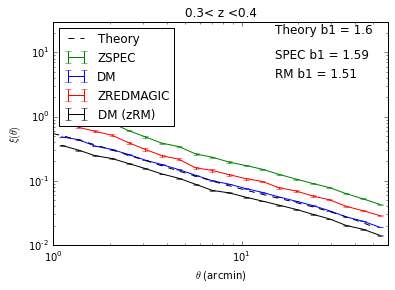

In [2]:
test = full_2pt_plot(.3,.1,False)

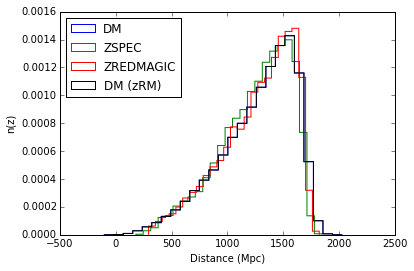

In [6]:
test.plot_nz()

In [7]:
len(test.full_gal_data)

399068

In [8]:
len(test.full_gal_RM_data)

433113

In [9]:
len(test.gal_data)

66780